In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import datasets, layers, models
from keras.applications import inception_resnet_v2
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import InputLayer,Dense,Flatten,GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,Dropout,Activation,Conv2D,MaxPooling2D
import os
import cv2
from keras.applications import inception_resnet_v2
from tensorflow.keras.models import Sequential, Model
import random

In [2]:
img_size = 32

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.4,
                                   zoom_range = 0.4,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('extracted_images_final/train',
                                                 target_size = (img_size, img_size),
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

Found 300746 images belonging to 82 classes.


In [4]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.4,
                                   zoom_range = 0.4,
                                   horizontal_flip = True)
validation_set = train_datagen.flow_from_directory('extracted_images_final/val',
                                                 target_size = (img_size, img_size),
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

Found 75161 images belonging to 82 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255.0)
                                 
test_set = test_datagen.flow_from_directory('extracted_images_final/test',
                                            target_size = (img_size, img_size),
                                            color_mode='grayscale',
                                            class_mode = 'categorical')

Found 75261 images belonging to 82 classes.


In [6]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (img_size,img_size,1)),
    layers.BatchNormalization(momentum=0.95),
    layers.MaxPool2D((2,2), padding='same'),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = "HeNormal"),
    layers.BatchNormalization(momentum=0.95),
    layers.MaxPool2D((2,2), padding='same'),
                    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(momentum=0.95),
    layers.MaxPool2D((2,2), padding='same'),
          
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(82, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath = r'model\equation_solver.h5', monitor = 'val_loss', verbose = 1, mode = 'min',
                            save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8, min_delta = 0.0001)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

callback = [earlystop, checkpoint, reduce_lr]

In [13]:
cnn_model = model.fit(x = training_set, validation_data = validation_set, epochs = 30, batch_size = 64,
                      callbacks = callback)

Epoch 1/30
9399/9399 [==============================] - 3349s 356ms/step - loss: 2.1395 - accuracy: 0.4633 - val_loss: 1.2941 - val_accuracy: 0.6540

Epoch 00001: val_loss improved from inf to 1.29411, saving model to model\equation_solver.h5
Epoch 2/30
9399/9399 [==============================] - 1424s 152ms/step - loss: 1.1129 - accuracy: 0.6867 - val_loss: 0.8752 - val_accuracy: 0.7582

Epoch 00002: val_loss improved from 1.29411 to 0.87519, saving model to model\equation_solver.h5
Epoch 3/30
9399/9399 [==============================] - 1578s 168ms/step - loss: 0.9183 - accuracy: 0.7359 - val_loss: 1.0293 - val_accuracy: 0.7075

Epoch 00003: val_loss did not improve from 0.87519
Epoch 4/30
9399/9399 [==============================] - 1545s 164ms/step - loss: 0.8286 - accuracy: 0.7606 - val_loss: 0.9100 - val_accuracy: 0.7449

Epoch 00004: val_loss did not improve from 0.87519
Epoch 5/30
9399/9399 [==============================] - 1489s 158ms/step - loss: 0.7689 - accuracy: 0.7776 -

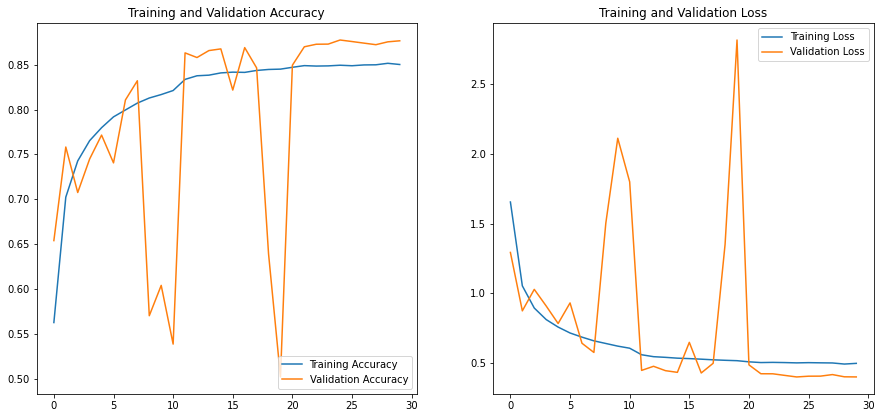

In [14]:
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
_, accuracy = model.evaluate(test_set)
print('accuracy in test_set: %.2f' %(accuracy*100),'%')

2352/2352 [==============================] - 395s 168ms/step - loss: 0.3355 - accuracy: 0.8960
accuracy in test_set: 89.60 %
